## Семинар 5: "Улучшение сходимости нейросетей"

ФИО: Новак Александр Вадимович

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms

from torch import device, cuda

DEVICE = device("cuda:0" if cuda.is_available() else "cpu")

import sys
from IPython.display import clear_output
%matplotlib inline

### утилиты на будущее

In [2]:
NUM_EPOCHS = 20

In [3]:
def _epoch(network, loss, loader,
           backward=True,
           optimizer=None,
           device=DEVICE,
           ravel_init=False):
    losses = []
    accuracies = []
    for X, y in loader:
        X = X.to(device)
        y = y.to(device)
        if ravel_init:
            X = X.view(X.size(0), -1)
        network.zero_grad()
        prediction = network(X)
        loss_batch = loss(prediction, y)
        losses.append(loss_batch.cpu().item())
        if backward:
            loss_batch.backward()
            optimizer.step()
        prediction = prediction.max(1)[1]
        accuracies.append((prediction==y).cpu().float().numpy().mean())
    return losses, accuracies


def train(network, train_loader, test_loader,
          epochs, learning_rate, ravel_init=False,
          device=DEVICE, tolerate_keyboard_interrupt=True):
    loss = nn.NLLLoss()
    optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    network = network.to(device)
    try:
        for epoch in range(epochs):
            network.train()
            losses, accuracies = _epoch(network,
                                        loss,
                                        train_loader,
                                        True,
                                        optimizer,
                                        device,
                                        ravel_init)
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))

            network.eval()
            losses, accuracies = _epoch(network,
                                        loss,
                                        test_loader,
                                        False,
                                        optimizer,
                                        device,
                                        ravel_init)

            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            print(
                f'Network: <{type(network).__name__}>\n'
                f'Optimizer: <{type(optimizer).__name__}>\n'
                f'Loss type: <{type(loss).__name__}>\n'
                f'Epoch: {epoch + 1}/{epochs}\n'
                f'<Train/Test>\n'
                f'Loss: {train_loss_epochs[-1]:.3f}/{test_loss_epochs[-1]:.3f}'
                f'| Accuracy: {train_accuracy_epochs[-1]:.3f}/{test_accuracy_epochs[-1]:.3f}'
            )

            plt.figure(figsize=(12, 5))

            plt.subplot(1, 2, 1)
            plt.plot(train_loss_epochs, label='Train')
            plt.plot(test_loss_epochs, label='Test')
            plt.xlabel('Epochs', fontsize=14)
            plt.ylabel('Loss', fontsize=14)
            plt.legend(fontsize=14)
            plt.grid('on')

            plt.subplot(1, 2, 2)
            plt.plot(train_accuracy_epochs, label='Train accuracy')
            plt.plot(test_accuracy_epochs, label='Test accuracy')
            plt.xlabel('Epochs', fontsize=14)
            plt.ylabel('Accuracy', fontsize=14)
            plt.legend(fontsize=14)
            plt.grid('on')
            plt.show()

    except KeyboardInterrupt:
        if tolerate_keyboard_interrupt:
            pass
        else:
            raise KeyboardInterrupt

    return train_loss_epochs, \
           test_loss_epochs, \
           train_accuracy_epochs, \
           test_accuracy_epochs


def compare_results(loss_results: list, acc_results: list, labels: list) -> None:
    plt.figure(figsize=(15, 7))

    plt.subplot(1, 2, 1)
    for loss_result, label in zip(loss_results, labels):
        plt.plot(loss_result, label=label)

    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(fontsize=10)
    plt.grid()

    plt.subplot(1, 2, 2)
    for acc_result, label in zip(acc_results, labels):
        plt.plot(acc_result, label=label)

    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Accuracy', fontsize=16)
    plt.legend(fontsize=10)
    plt.grid()
    plt.show()

## Описание задания:
Вам необходимо реализовать оставшиеся методы из лекции и сравнить их на примере из семинара.

## Задание разделено на следующие части:
1. Реализация Xavier **(1 балл)**

2.1 Реализация DropConnect **(1 балл)**

2.2 Сравнение обучения при использовании Dropout и DropConnect **(1 балл)**

3.1 Реализация LayerNorm **(1 балл)**

3.2 Сравнение обучения при использовании BatchNorm и LayerNorm **(1 балл)**

## Срок выполнения задания:
Данное задание можно сдать без штрафов до 16 октября.


### Часть 1: Инициализация весов

Будем использовать MNIST для обучения:

In [4]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [5]:
images_train, labels_train = next(iter(train_loader))

In [6]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    break

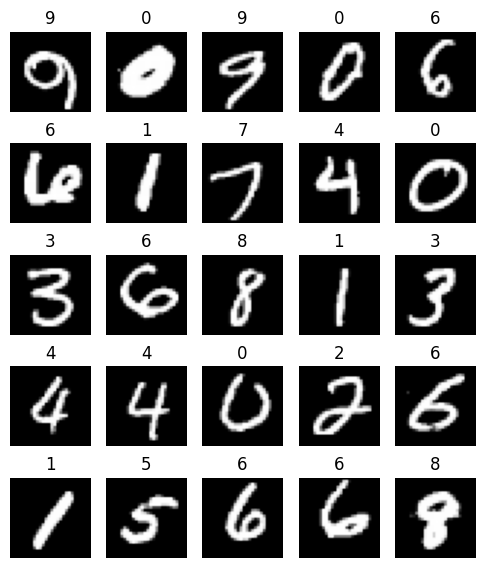

In [7]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

In [8]:
def init_layer(layer, mean=0, std=1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=std)

def forward_hook(self, input_, output):
    std = input_[0].std().item()
    print('forward', std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print('backward', std)

На вход передаем изображение 28x28, на выходе -- вероятности 10 классов.

In [9]:
layer_1 = nn.Linear(28*28, 500)
layer_2 = nn.Linear(500, 10)

layer_1.register_forward_hook(forward_hook)
layer_2.register_forward_hook(forward_hook)

layer_1.register_backward_hook(backward_hook)
layer_2.register_backward_hook(backward_hook)

init_layer(layer_1)
init_layer(layer_2)

Соберем все вместе, используя ReLU в качестве функции активации:

In [10]:
network = nn.Sequential(
    layer_1,
    nn.ReLU(),
    layer_2
)

#### 1.1 Реализуйте инициализацию Xavier. Сравните ее с He, которая была реализована на семинаре, сделайте выводы. Учтите, что для Xavier необходимо использовать функцию активации nn.Tanh(). **(1 балл)**

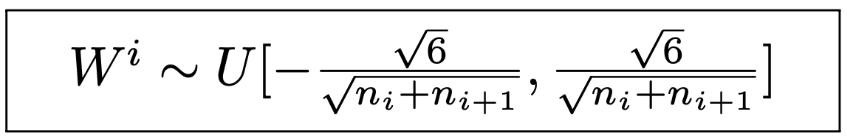

In [11]:
##### YOUR CODE HERE #####
def xavier(size_input, size_output):
    d = 6 / (size_input + size_output)
    return np.sqrt(d)

def xavier_init_layer(layer, size_input, size_output):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    a_range = np.sqrt(6 / (size_input + size_output))
    weight.uniform_(-a_range, a_range)

In [12]:
sizes = [28*28, 64, 32] + [16] * 30 + [10]
layers = []

for size_input, size_output in zip(sizes, sizes[1:]):

    layer = nn.Linear(size_input, size_output)
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)

    xavier_init_layer(layer, size_input, size_output)

    layers.append(layer)
    layers.append(nn.Tanh())

print(len(layers))
del layers[-1]

66


In [13]:
network = nn.Sequential(*layers)

n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data

activations = network(X)

loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss = loss_fn(activations, y)
loss.backward()

forward 1.0048233270645142
forward 0.7196393013000488
forward 0.5822457671165466
forward 0.48825496435165405
forward 0.3741016089916229
forward 0.33797505497932434
forward 0.2890104055404663
forward 0.2590240240097046
forward 0.2630012333393097
forward 0.2376137375831604
forward 0.1919260025024414
forward 0.19180594384670258
forward 0.17907842993736267
forward 0.17406673729419708
forward 0.19680249691009521
forward 0.22095181047916412
forward 0.22765955328941345
forward 0.202482670545578
forward 0.1959146410226822
forward 0.1931954175233841
forward 0.18725652992725372
forward 0.19217073917388916
forward 0.18755008280277252
forward 0.15408433973789215
forward 0.14891526103019714
forward 0.10120069980621338
forward 0.09489017724990845
forward 0.09993234276771545
forward 0.09923624992370605
forward 0.1167592853307724
forward 0.10561271756887436
forward 0.10554458200931549
forward 0.10830745846033096
backward 0.03559026122093201
backward 0.1043345183134079
backward 0.13261622190475464
back

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


## He-initialisation

In [14]:
def he_init_layer(layer, mean=0, std=1):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=mean, std=std)

def he_forward(size_input, size_output):
    return np.sqrt(2 / size_input)

def he_backward(size_input, size_output):
    return np.sqrt(2 / size_output)

In [15]:
sizes = [28*28, 64, 32] + [16] * 30 + [10]
layers = []

for size_input, size_output in zip(sizes, sizes[1:]):

    layer = nn.Linear(size_input, size_output)
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)

    he_init_layer(layer, 0, he_backward(size_input, size_output))

    layers.append(layer)
    layers.append(nn.ReLU())

print(len(layers))
del layers[-1]

66


In [16]:
network = nn.Sequential(*layers)

n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data

activations = network(X)

loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss = loss_fn(activations, y)
loss.backward()

forward 1.0048233270645142
forward 3.180055618286133
forward 4.511306285858154
forward 5.805266380310059
forward 6.362027645111084
forward 8.906110763549805
forward 8.71815013885498
forward 6.776641845703125
forward 4.895941734313965
forward 7.862009048461914
forward 6.420166492462158
forward 4.96243953704834
forward 4.410872459411621
forward 3.8559346199035645
forward 4.747076034545898
forward 5.858678340911865
forward 6.609814643859863
forward 4.7176103591918945
forward 5.981102466583252
forward 6.0826921463012695
forward 4.0162506103515625
forward 2.909912586212158
forward 2.494281530380249
forward 3.17118501663208
forward 4.9025678634643555
forward 3.058561325073242
forward 3.4969749450683594
forward 3.6411871910095215
forward 2.1579415798187256
forward 2.4806406497955322
forward 2.435185670852661
forward 3.430872678756714
forward 4.336311340332031
backward 0.03559026122093201
backward 0.122711680829525
backward 0.11194861680269241
backward 0.0896577537059784
backward 0.06700627505

Инициализация Xavier показала более хорошую начальную ошибку. Определённые скачки наблюдались с обеими вариантами инициализации.

## Часть 2: DropConnect

#### 2.1 Реализуйте DropConnect по следующему шаблону: **(1 балл)**

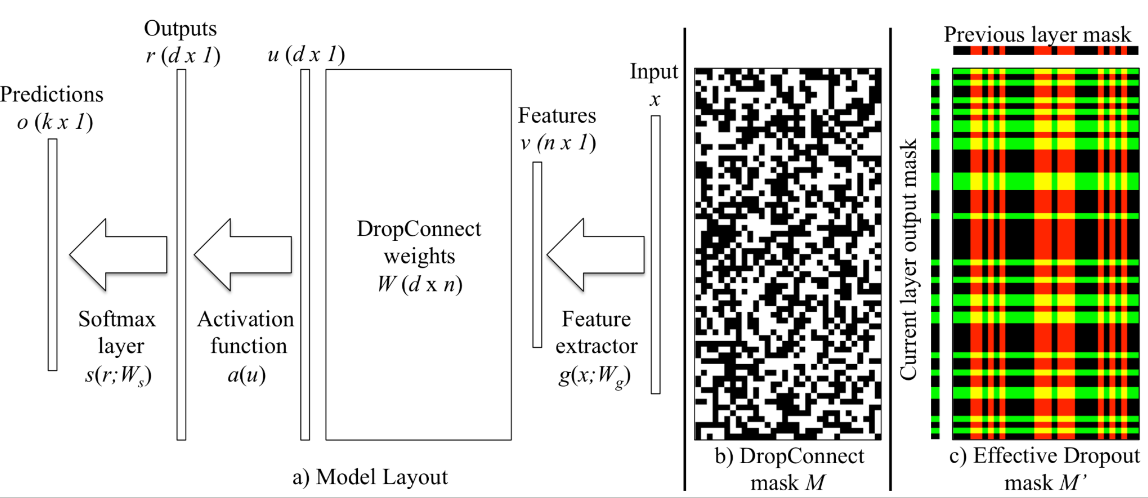

In [17]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры

class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5):
        super(DropConnect, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.p = p

    def forward(self, x):
        mask = torch.zeros_like(self.linear.weight) + self.p
        if self.training:
            mask.bernoulli_(self.p)

        mask = mask.data
        output = F.linear(x, self.linear.weight * mask, self.linear.bias)
        return output

Основа для сети, которую будем обучать:

In [18]:
class TestNetwork(nn.Module):
    def __init__(self, final_part):
        super().__init__()

        channels = 1

        self.conv_layers = nn.Sequential(
            nn.Conv2d(channels, 2, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(2, 4, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )

        #input_size = 7 * 7 * 4 = 196
        self.flatten = nn.Flatten()

        self.final_part = final_part

        self.log_softmax = nn.LogSoftmax(1)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.final_part(x)
        return self.log_softmax(x)

Добавим несколько слоев в конец сети:

In [19]:
# Dropout и ReLU после каждого слоя
sizes = [196, 128, 128, 10]
w_dropout_layers = []
for size_input, size_output in zip(sizes, sizes[1:]):
    w_dropout_layers.append(nn.Linear(size_input, size_output))
    w_dropout_layers.append(nn.Dropout(0.3))
    w_dropout_layers.append(nn.ReLU())

# исключим dropout и relu с последних слоев
del w_dropout_layers[-2:]

In [20]:
# dropconnect
# dropconnect_layers = [nn.ReLU(), DropConnect(196, 10, p=0.8)]
dropconnect_layers = []
for size_input, size_output in zip(sizes, sizes[1:]):
    dropconnect_layers.append(DropConnect(size_input, size_output, 0.8))
    dropconnect_layers.append(nn.ReLU())

del dropconnect_layers[-1]

In [21]:
network_dropout = TestNetwork(nn.Sequential(*w_dropout_layers))
network_dropconnect = TestNetwork(nn.Sequential(*dropconnect_layers))
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss_fn = torch.nn.NLLLoss()

Обучим получившуюся сеть:

Network: <TestNetwork>
Optimizer: <Adam>
Loss type: <NLLLoss>
Epoch: 20/20
<Train/Test>
Loss: 0.056/0.046| Accuracy: 0.982/0.985


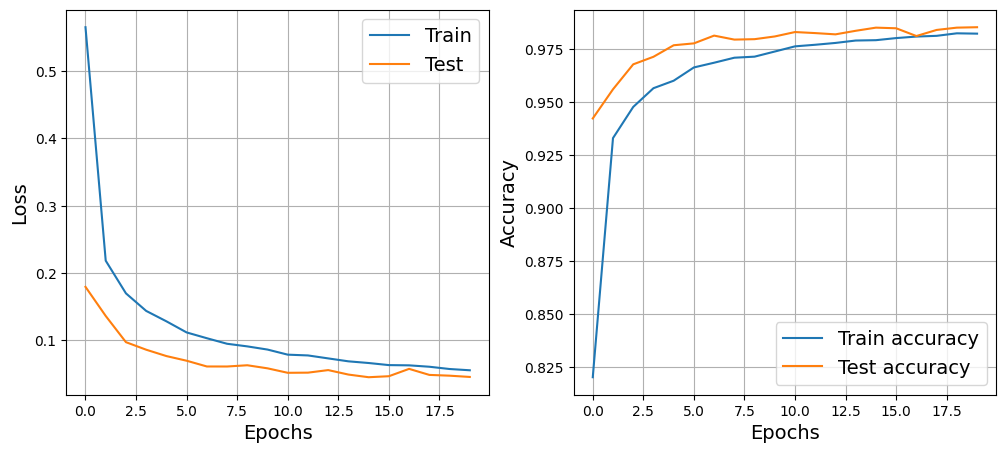

([0.5652159134875229,
  0.21836391749031253,
  0.16982430263337042,
  0.1437580299371087,
  0.12828439530898642,
  0.11177088052177353,
  0.10317590275505331,
  0.09493308654750016,
  0.0910461931697913,
  0.08632291197133407,
  0.07874930682661596,
  0.0775983070255692,
  0.07318866994978586,
  0.06883662601889197,
  0.0663489122172075,
  0.06323882573738948,
  0.0628765323507125,
  0.060803546432230966,
  0.05743309082503099,
  0.05555209236394273],
 [0.1794782321475729,
  0.13624390094434913,
  0.0973093070655684,
  0.08612297138175633,
  0.07665751152966596,
  0.06974126589543457,
  0.06119863981052443,
  0.06115535834120422,
  0.06300371473867304,
  0.05843897976122702,
  0.05179874423914884,
  0.052024520344183416,
  0.05582490986466549,
  0.04917085299981593,
  0.04523200161542885,
  0.046724898351615744,
  0.05764202724647107,
  0.04867700901754861,
  0.04752796002121383,
  0.045638557877155796],
 [0.8201181,
  0.9328803,
  0.94757795,
  0.9564066,
  0.9599436,
  0.96620136,
  

In [22]:
train(network_dropout, train_loader, test_loader, NUM_EPOCHS, 0.001)

Network: <TestNetwork>
Optimizer: <Adam>
Loss type: <NLLLoss>
Epoch: 20/20
<Train/Test>
Loss: 0.053/0.053| Accuracy: 0.983/0.983


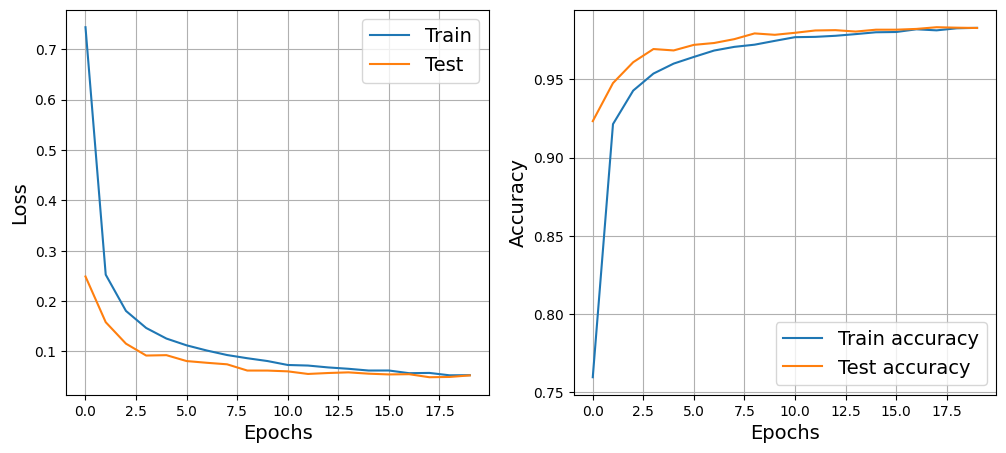

([0.7436376028795486,
  0.2524977290808265,
  0.1805727237672694,
  0.1466996306930778,
  0.12569194563082667,
  0.11220581051724743,
  0.10192180821286843,
  0.09297516814141131,
  0.08663745554310999,
  0.08103657796629456,
  0.07323065404889426,
  0.07210325927082409,
  0.06837488330606777,
  0.06568199337454143,
  0.06221957170843347,
  0.06227594205557601,
  0.05694576106798738,
  0.05748146458832758,
  0.05276208369236098,
  0.05297143937948384],
 [0.24886892915149278,
  0.1581739323048652,
  0.11557559555844416,
  0.0919622112466376,
  0.09272747971353275,
  0.08100087576416097,
  0.07759066226691762,
  0.07456419864504397,
  0.06218589868697137,
  0.06213093348601951,
  0.06058490569880114,
  0.055423902857553546,
  0.057297104185659295,
  0.05859851367370803,
  0.05594742298126221,
  0.054470530316186476,
  0.054947100402905215,
  0.048937290786806774,
  0.04948540587166819,
  0.05255624320935694],
 [0.75959486,
  0.92136973,
  0.9428027,
  0.9536636,
  0.960038,
  0.9643079,


In [23]:
train(network_dropconnect, train_loader, test_loader, NUM_EPOCHS, 0.001)


#### 2.2 Сравните графики обучения нейроных сетей **(1 балл)**:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Dropout между всеми слоями
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и DropConnect вместо всех линейных слоев


Качество с Dropout лучше, чем с DropConnect. При этом отчетливо видно, что качество модели на трейне много хуже, чем на тесте. Стратегия зануления нейронов или слоев "затрудняет" предсказание модели, но при их обратном включении всё становится хорошо (как ансамбль нейронок).

### Часть 3: Batch Normalization

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

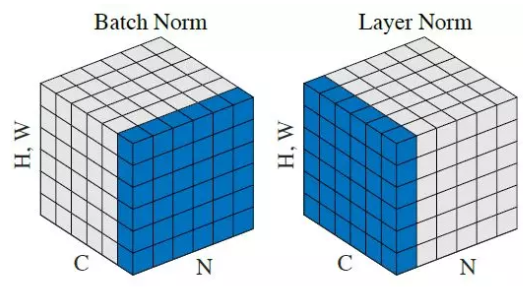

#### 3.1 Реализуйте Layer Normalization **(1 балл)**

In [24]:
# полезные функции: .std(dim), .mean(dim)

class LayerNormalization(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.alpha = nn.Parameter(torch.ones(input_dim))
        self.beta = nn.Parameter(torch.zeros(input_dim))

    def forward(self, x):
        output = self.alpha * (x - x.mean()) / (x.std() + 1e-8) + self.beta
        return output

#### 3.2 Сравните графики обучения нейроных сетей **(1 балл)**:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Batch normalization между всеми слоями
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Layer normalization между всеми слоями

In [25]:
##### YOUR CODE HERE #####
relu_batch_normed_layers = []
for in_dim, out_dim in zip(sizes, sizes[1:]):
    relu_batch_normed_layers.append(nn.Linear(in_dim, out_dim))
    relu_batch_normed_layers.append(nn.BatchNorm1d(out_dim))
    relu_batch_normed_layers.append(nn.ReLU())

del relu_batch_normed_layers[-2:]

In [26]:
relu_layer_normed_layers = []
for in_dim, out_dim in zip(sizes, sizes[1:]):
    relu_layer_normed_layers.append(nn.Linear(in_dim, out_dim))
    relu_layer_normed_layers.append(LayerNormalization(out_dim))
    relu_layer_normed_layers.append(nn.ReLU())

del relu_layer_normed_layers[-2:]

In [27]:
batch_network = TestNetwork(nn.Sequential(*relu_batch_normed_layers))
layer_network = TestNetwork(nn.Sequential(*relu_layer_normed_layers))

Network: <TestNetwork>
Optimizer: <Adam>
Loss type: <NLLLoss>
Epoch: 20/20
<Train/Test>
Loss: 0.011/0.068| Accuracy: 0.996/0.984


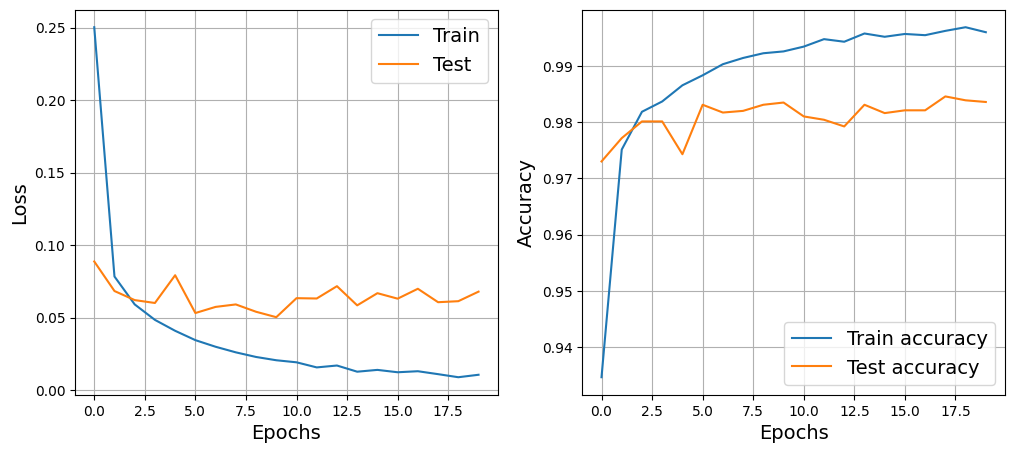

([0.2503056330189331,
  0.07838563251692349,
  0.05914539022089195,
  0.04847283476788892,
  0.040937244670707855,
  0.03449408986123163,
  0.02993305823204717,
  0.026078541362251063,
  0.022893688971621553,
  0.0206286231567686,
  0.019209410916186814,
  0.015693864735987172,
  0.01699418054916201,
  0.012735352398820721,
  0.013980480230305153,
  0.01234777918839301,
  0.013057479330842177,
  0.011034012536643874,
  0.008923754987948791,
  0.010618608031688861],
 [0.08875163804881181,
  0.06837491514279118,
  0.06211074024344547,
  0.06012497677267352,
  0.07926437033552534,
  0.053193226282755975,
  0.05742440380073518,
  0.059123069890833733,
  0.054071053878781444,
  0.050324356292456955,
  0.06344001084754738,
  0.06322088419707327,
  0.07171236200824002,
  0.05849022059583494,
  0.06688143826337366,
  0.06310121316604222,
  0.0699256148207358,
  0.06066236365861095,
  0.06135991398875802,
  0.06794861456028575],
 [0.9346127,
  0.9751188,
  0.981843,
  0.98367536,
  0.98655164,


In [29]:
no_out = train(batch_network, train_loader, test_loader, NUM_EPOCHS, 0.001)

Network: <TestNetwork>
Optimizer: <Adam>
Loss type: <NLLLoss>
Epoch: 20/20
<Train/Test>
Loss: 0.013/0.052| Accuracy: 0.995/0.987


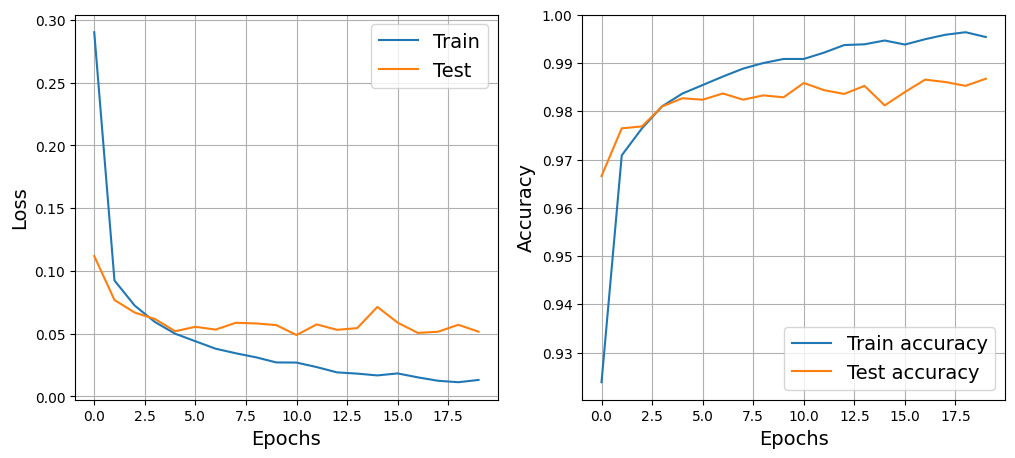

([0.2901626498555578,
  0.09239128780072686,
  0.07240312046278069,
  0.05929347828550856,
  0.04998366175733729,
  0.04397655120377601,
  0.03803441153743914,
  0.03438242913773859,
  0.031166961753437084,
  0.027092684728792435,
  0.02698683935795416,
  0.023383142256454974,
  0.01918490673551884,
  0.018182258831455248,
  0.01675933067610404,
  0.018342177300944305,
  0.015198114217628341,
  0.012479835293572971,
  0.01133034534414541,
  0.013148519112377305],
 [0.11183025481037889,
  0.0768140016618786,
  0.06683517282805111,
  0.061668403240368715,
  0.051936084546054466,
  0.05548818738353026,
  0.05323261857810843,
  0.05868313840260329,
  0.05814725883257917,
  0.056843923285450265,
  0.0489243115681589,
  0.057411040898553936,
  0.05308546860926325,
  0.05441640729019772,
  0.07132843120135603,
  0.05880584751102555,
  0.05059278109759281,
  0.05157688809146138,
  0.05708432971253767,
  0.05159172614597232],
 [0.92384064,
  0.97086,
  0.97646254,
  0.9810323,
  0.98367536,
  0

In [30]:
no_out = train(layer_network, train_loader, test_loader, NUM_EPOCHS, 0.001)

Layer оказался чуть лучше.

Стоит отметить, что оба метода явно позволили избавиться от переобучения: точность на train продолжала расти как при переобучении, но при этом точность на тесте не начала падать.